# **Food-101 Image Classification**

The purpose of the project is to gain a deeper understanding of managing ML projects. To achieve this, we are encouraged to build and deploy an ML component. With a strong emphasis on practical application, our project consists of an image classification tool. Specifically, a neural network capable of accurately classifying food images.

We have developed and deployed an automated food recognition tool where users are able to upload images and the application will them which food is it. Then, users can look for information about that dish: Is it typical? What is the story behind it? How much protein or fat does it contain? Therefore, the implications of this project are far- reaching, such as knowing meaningful information about dishes or aiding in dietary assessment.

The key takeaway here is that greater accuracy in the reports provides more authentic information. Therefore, the food classifier needs to be very precise. Fortunately, nowadays, thanks to the appearance of deep learning, all this is possible.

Eventually, we look forward to integrating this emergent technology into our day-to- day life and improving its quality.

## **Installation and import of libraries**

In [2]:
# Import all libraries needed
import os
import ast
import shutil
import urllib
import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import dagshub

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from PIL import Image
from typing import Tuple, List
from matplotlib.pyplot import imshow
from codecarbon import EmissionsTracker
from torch.utils.data import DataLoader
from typing import Tuple, Dict, Any, List
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [4]:
torch.set_grad_enabled(True)
%matplotlib inline

In [5]:
dagshub.init("taed2-Food_Classification", "violeta51", mlflow=True)

mlflow.set_tracking_uri('https://dagshub.com/violeta51/taed2-Food_Classification.mlflow')
mlflow.set_experiment(experiment_name="REPORT INICIAL")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=ad120e36-7fea-4c1e-adf1-aa33f54b8977&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=dc49b5d078ba861b63a82fdfbd0f7f82d5edb0134fff6d68fd271129f000746d




Repository initialized!

<Experiment: artifact_location='mlflow-artifacts:/62f4f6b488564b148a8d5dcc870cb0e6', creation_time=1696057452443, experiment_id='2', last_update_time=1696057452443, lifecycle_stage='active', name='REPORT INICIAL', tags={}>

## **Initialization**

Let's set the working enviroment.

In [6]:
# Set a seed for garantee the replication once we finish get the model
seed = 7767
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

Since the model is fairly complex, training it in the GPU will save us time.

In [7]:
# We select to work on GPU
if not torch.cuda.is_available():
       raise RuntimeError("You should enable GPU runtime!!")
device = torch.device("cuda")

In [8]:
# Let's define some hyper-parameters
hparams = {
    'log_interval': 200,
    'epochs' : 20,
    'batch_size' : 64,
}

mlflow.log_param("log_interval", hparams["log_interval"])
mlflow.log_param("epochs", hparams["epochs"])
mlflow.log_param("batch_size", hparams["batch_size"])

64

## **Load the Data**
Since the training data are off-line, we need to load them.

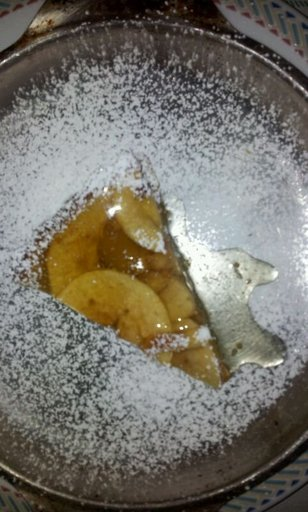

In [9]:
# Open an image

Image.open('/kaggle/input/data-food/external/apple_pie/1005649.jpg')

In [10]:
# The following code is a modified version of the 
# code extracted from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file # file containing the labels
        self.img_dir = img_dir # directory containing the images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self): # returns the number of samples in our dataset.
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
            
        image = read_image(img_path)

        to_pil = transforms.ToPILImage()
        image = to_pil(image)
        
        width, height = image.size
        
        if width < 224 or height < 224:
            scale_factor = 512 / max(width, height)
    
        # Calculate the new dimensions
            new_width = int(width * scale_factor)
            new_height = int(height * scale_factor)

            image = image.resize((new_height, new_width))
        
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [11]:
# Define the composed transformation for training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(p=0.5), transforms.ToTensor(),])
mlflow.log_param("data_augmentation", "RandomResizedCrop(224), RandomHorizontalFlip(p=0.5)")

'RandomResizedCrop(224), RandomHorizontalFlip(p=0.5)'

In [12]:
# Read the folders and load them in a specific class structure
first = False
first_first = True

# Transform the target 'words' into numerical values, this dictionary will associate these two values
dictionary = {} 
idx = 0

for dirname, _, filenames in os.walk('/kaggle/input/data-food/external/'):

    if first == True:
        label = dirname[len('/kaggle/input/data-food/external/'):]
        columns = ['file', 'label']
        target = pd.DataFrame(columns=columns)
        
        for filename in filenames:
            target.loc[len(target)] = [filename, idx]
        
        dictionary[idx] =  label
        sub_dataset = CustomImageDataset(target, dirname, transform = train_transforms)
        
        if first_first == True:
            train_data = sub_dataset
            first_first = False
        else:
            train_data = ConcatDataset([train_data, sub_dataset])
        
        idx = idx + 1
        
    first = True     

In [13]:
# Show a sample
train_data[2]

(tensor([[[0.0471, 0.0353, 0.0235,  ..., 0.3059, 0.3412, 0.3451],
          [0.0392, 0.0314, 0.0157,  ..., 0.2824, 0.3216, 0.3451],
          [0.0314, 0.0196, 0.0118,  ..., 0.2667, 0.2745, 0.3059],
          ...,
          [0.4980, 0.4980, 0.4980,  ..., 0.3333, 0.3255, 0.3255],
          [0.5020, 0.5020, 0.5020,  ..., 0.3451, 0.3412, 0.3373],
          [0.4980, 0.4941, 0.4902,  ..., 0.3608, 0.3608, 0.3529]],
 
         [[0.0431, 0.0353, 0.0235,  ..., 0.1529, 0.1882, 0.1882],
          [0.0353, 0.0275, 0.0157,  ..., 0.1333, 0.1686, 0.1843],
          [0.0275, 0.0196, 0.0118,  ..., 0.1412, 0.1412, 0.1608],
          ...,
          [0.3255, 0.3255, 0.3255,  ..., 0.2627, 0.2549, 0.2510],
          [0.3333, 0.3373, 0.3333,  ..., 0.2667, 0.2627, 0.2627],
          [0.3294, 0.3333, 0.3333,  ..., 0.2824, 0.2784, 0.2706]],
 
         [[0.0353, 0.0314, 0.0235,  ..., 0.1882, 0.2196, 0.2235],
          [0.0275, 0.0275, 0.0157,  ..., 0.1686, 0.2039, 0.2235],
          [0.0196, 0.0196, 0.0118,  ...,

In [14]:
# Split into training and validation set
train_subset, val_subset = torch.utils.data.random_split(
train_data, [20000, 10000], generator=torch.Generator().manual_seed(7767))

In [15]:
val_subset[14]

(tensor([[[0.7765, 0.7725, 0.7608,  ..., 0.7529, 0.5961, 0.4510],
          [0.7725, 0.7569, 0.7569,  ..., 0.8118, 0.7059, 0.5647],
          [0.7843, 0.7490, 0.7529,  ..., 0.8235, 0.7608, 0.6627],
          ...,
          [0.3922, 0.3961, 0.4000,  ..., 0.3569, 0.3294, 0.3216],
          [0.3961, 0.3922, 0.4039,  ..., 0.3608, 0.3333, 0.3294],
          [0.4039, 0.3961, 0.4078,  ..., 0.3647, 0.3412, 0.3216]],
 
         [[0.5843, 0.5843, 0.5765,  ..., 0.6392, 0.4784, 0.3216],
          [0.5804, 0.5647, 0.5765,  ..., 0.7098, 0.5922, 0.4471],
          [0.5804, 0.5490, 0.5647,  ..., 0.7373, 0.6667, 0.5647],
          ...,
          [0.3725, 0.3725, 0.3765,  ..., 0.1843, 0.1608, 0.1569],
          [0.3804, 0.3765, 0.3843,  ..., 0.1961, 0.1686, 0.1725],
          [0.3882, 0.3804, 0.3843,  ..., 0.2078, 0.1922, 0.1765]],
 
         [[0.2275, 0.2431, 0.2627,  ..., 0.5529, 0.4000, 0.2431],
          [0.2235, 0.2275, 0.2667,  ..., 0.6196, 0.5098, 0.3608],
          [0.2275, 0.2196, 0.2549,  ...,

### Data Loader 
Once the data are loaded in the workspace, we can prepare the data to feed them into the model.

In [16]:
train_loader = torch.utils.data.DataLoader(
    train_subset, 
    batch_size=hparams["batch_size"], 
    shuffle=True,
    num_workers=1, 
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=hparams["batch_size"],
    shuffle=False, 
    num_workers=1,
)

## **Training**

### Utils: useful functions for the training
Some useful function will needed later. Here we include some definition of them. 

In [17]:
def adjust_learning_rate(
        optimizer: torch.optim, 
        epoch: int, 
        original_lr: float
        ) -> None:
    
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    
    lr = original_lr * (0.1 ** (epoch // 30))
    # For some models, different parameters are in different groups with different lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [18]:
def compute_accuracy(predicted_batch: torch.Tensor, label_batch: torch.Tensor) -> float:
    """
    Define the Accuracy metric in the function below by:
      (1) obtain the maximum for each predicted element in the batch to get the
        class (it is the maximum index of the num_classes array per batch sample)
        (look at torch.argmax in the PyTorch documentation)
      (2) compare the predicted class index with the index in its corresponding
        neighbor within label_batch
      (3) sum up the number of affirmative comparisons and return the summation

    Parameters:
    -----------
    predicted_batch: torch.Tensor shape: [BATCH_SIZE, N_CLASSES]
        Batch of predictions
    label_batch: torch.Tensor shape: [BATCH_SIZE, 1]
        Batch of labels / ground truths.
    """

    pred = predicted_batch.argmax(dim=1, keepdim=True) # Get the index of the max log-probability 
    acum = pred.eq(label_batch.view_as(pred)).sum().item()
    return acum

In [19]:
def save_checkpoint(
        state: 'dict', 
        is_best: bool, 
        filename: str = 'checkpoint.pth.tar'
        ) -> None:
    
    torch.save(state, filename)
    
    # Save an extra copy if it is the best model yet
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')  

### Define the training



In [20]:
# Obtain the model from pytorch
model = models.resnet34()
learning_rate = 0.01

# Declare Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mlflow.log_param("optimizer", optimizer)
mlflow.log_param("lr", learning_rate)

# Define the loss function
criterion = nn.CrossEntropyLoss()

In [21]:
def train_epoch(
        train_loader: torch.utils.data.DataLoader, 
        model: torch.nn.Module, 
        optimizer: torch.optim,
        criterion: torch.nn, 
        epoch: int,
        log_interval: int,
        device: torch.device
        ) -> Tuple[float, float]:

    # Switch to train mode (activate the train=True flag inside the model)
    model.train()
    
    train_loss = []
    acc = 0.
    avg_weight = 0.1
    
    for i in range(len(train_loader)):
        batch = next(iter(train_loader))
        images = batch[0]
        target = batch[1]
        
        # Set network gradients to 0.
        optimizer.zero_grad()

        # Move images to gpu
        images = images.to(device)
        target = target.to(device)

        # Forward batch of images through the network
        output = model(images)
        loss = criterion(output, target) # Compute the loss

        # Compute gradient and do SGD step
        loss.backward()
        optimizer.step()
        
        # Compute metrics
        acc += compute_accuracy(output, target)
        train_loss.append(loss.item())

        if i % log_interval == 0 or i >= len(train_loader)-1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),
                100. * i / len(train_loader), loss.item()))
    avg_acc = 100. * acc / len(train_loader.dataset)
    
    return np.mean(train_loss), avg_acc 

In [22]:
@torch.no_grad() # Decorator: avoid computing gradients
def eval_epoch(
        test_loader: torch.utils.data.DataLoader,
        model: torch.nn.Module,
        criterion: torch.nn.functional,
        ) -> Tuple[float, float]:

    # Dectivate the train=True flag inside the model
    model.eval()
    
    test_loss = 0
    acc = 0
    for i in range(len(test_loader)):
        batch = next(iter(test_loader))
        data = batch[0]
        target = batch[1]
        
        data, target = data.to(device), target.to(device)

        output = model(data)

        # Apply the loss criterion and accumulate the loss
        test_loss += criterion(output, target).item()

        # Compute number of correct predictions in the batch
        acc += compute_accuracy(output, target)

    test_loss /= len(test_loader)
    # Average accuracy across all correct predictions batches now
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc # It returns the metrics in the validation depending on the epochs

In [23]:
def train_net(
        network: torch.nn.Module,
        train_loader: torch.utils.data.DataLoader,
        eval_loader: torch.utils.data.DataLoader,    
        optimizer: torch.optim,
        num_epochs: int,
        plot: bool=True,
        ) -> Dict[str, List[float]]:
    
    """ 
    Function that trains and evals a network for num_epochs,
    showing the plot of losses and accs and returning them.
    """
    tr_losses = []
    tr_accs = []
    te_losses = []
    te_accs = []

    network.to(device)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, num_epochs + 1):
        tr_loss, tr_acc = train_epoch(train_loader, network, optimizer, criterion, epoch, hparams["log_interval"],device)
        mlflow.log_metric("loss_train", tr_loss, step=epoch)
        mlflow.log_metric("accuracy_train", tr_acc, step=epoch)
        te_loss, te_acc = eval_epoch(eval_loader, network, criterion)
        mlflow.log_metric("loss_eval", te_loss, step=epoch)
        mlflow.log_metric("accuracy_eval", te_acc, step=epoch)
        te_losses.append(te_loss)
        te_accs.append(te_acc)
        tr_losses.append(tr_loss)
        tr_accs.append(tr_acc)
    rets = {'tr_losses':tr_losses, 'te_losses':te_losses,
          'tr_accs':tr_accs, 'te_accs':te_accs}
    
    if plot:
        plt.figure(figsize=(10, 8))
        plt.subplot(2,1,1)
        plt.xlabel('Epoch')
        plt.ylabel('NLLLoss')
        plt.plot(tr_losses, label='train')
        plt.plot(te_losses, label='eval')
        plt.legend()
        plt.subplot(2,1,2)
        plt.xlabel('Epoch')
        plt.ylabel('Eval Accuracy [%]')
        plt.plot(tr_accs, label='train')
        plt.plot(te_accs, label='eval')
        plt.legend()
    
    # Save model
    torch.save(network.state_dict(), "RESNET50")
    
    return rets

### Model Parameters

In [24]:
def get_nn_nparams(net: torch.nn.Module) -> int:
  """
  Function that returns all parameters regardless of the require_grad value.
  https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/6
  """
  return sum([torch.numel(p) for p in list(net.parameters())])

In [25]:
# Let's see the number of parameters containing in our network
print("Number of parameters:", get_nn_nparams(model))

Number of parameters: 21797672


### Train the model and check its performance

[codecarbon INFO @ 21:19:09] [setup] RAM Tracking...
[codecarbon INFO @ 21:19:09] [setup] GPU Tracking...
[codecarbon INFO @ 21:19:10] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 21:19:10] [setup] CPU Tracking...
[codecarbon WARNING @ 21:19:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:19:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 21:19:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 21:19:11] >>> Tracker's metadata:
[codecarbon INFO @ 21:19:11]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 21:19:11]   Python version: 3.10.12
[codecarbon INFO @ 21:19:11]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 21:19:11]   Available RAM : 31.358 GB
[codecarbon INFO @ 21:19:11]   CPU count: 4
[codecarbon INFO @ 21:19:11]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 21:19:11]   GPU

Train Epoch: 1 [0/20000 (0%)]	Loss: 6.934446


[codecarbon INFO @ 21:19:29] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:19:29] Energy consumed for all GPUs : 0.000158 kWh. Total GPU Power : 37.94214120621689 W
[codecarbon INFO @ 21:19:29] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:19:29] 0.000385 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:44] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:19:44] Energy consumed for all GPUs : 0.000360 kWh. Total GPU Power : 48.432007571491596 W
[codecarbon INFO @ 21:19:44] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:19:44] 0.000812 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:59] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:19:59] Energy consumed for all GPUs : 0.000562 kWh. Total GPU Power : 48.4287131777290

Train Epoch: 1 [12800/20000 (64%)]	Loss: 3.228112


[codecarbon INFO @ 21:24:29] Energy consumed for RAM : 0.001029 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:24:30] Energy consumed for all GPUs : 0.004546 kWh. Total GPU Power : 56.10536165130904 W
[codecarbon INFO @ 21:24:30] Energy consumed for all CPUs : 0.003724 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:24:30] 0.009300 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:24:45] Energy consumed for RAM : 0.001079 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:24:45] Energy consumed for all GPUs : 0.004783 kWh. Total GPU Power : 56.34823075917098 W
[codecarbon INFO @ 21:24:45] Energy consumed for all CPUs : 0.003903 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:24:45] 0.009765 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:25:00] Energy consumed for RAM : 0.001127 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:25:00] Energy consumed for all GPUs : 0.005017 kWh. Total GPU Power : 56.20789303631964

Train Epoch: 1 [19968/20000 (100%)]	Loss: 3.303988


[codecarbon INFO @ 21:26:45] Energy consumed for RAM : 0.001470 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:26:45] Energy consumed for all GPUs : 0.006662 kWh. Total GPU Power : 52.082768378828625 W
[codecarbon INFO @ 21:26:45] Energy consumed for all CPUs : 0.005320 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:26:45] 0.013452 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:27:00] Energy consumed for RAM : 0.001519 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:27:00] Energy consumed for all GPUs : 0.006850 kWh. Total GPU Power : 45.16398386112459 W
[codecarbon INFO @ 21:27:00] Energy consumed for all CPUs : 0.005497 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:27:00] 0.013866 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:27:15] Energy consumed for RAM : 0.001568 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:27:15] Energy consumed for all GPUs : 0.007045 kWh. Total GPU Power : 46.9343908226743


Test set: Average loss: 3.3155, Accuracy: 583/10000 (6%)

Train Epoch: 2 [0/20000 (0%)]	Loss: 3.344776


[codecarbon INFO @ 21:29:15] Energy consumed for RAM : 0.001960 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:29:15] Energy consumed for all GPUs : 0.008605 kWh. Total GPU Power : 45.29520584222844 W
[codecarbon INFO @ 21:29:15] Energy consumed for all CPUs : 0.007091 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:29:15] 0.017656 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:29:30] Energy consumed for RAM : 0.002009 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:29:30] Energy consumed for all GPUs : 0.008840 kWh. Total GPU Power : 56.300997308881904 W
[codecarbon INFO @ 21:29:30] Energy consumed for all CPUs : 0.007268 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:29:30] 0.018117 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:29:45] Energy consumed for RAM : 0.002058 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:29:45] Energy consumed for all GPUs : 0.009075 kWh. Total GPU Power : 56.5648019054366

Train Epoch: 2 [12800/20000 (64%)]	Loss: 3.104120


[codecarbon INFO @ 21:33:15] Energy consumed for RAM : 0.002744 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:33:15] Energy consumed for all GPUs : 0.012469 kWh. Total GPU Power : 58.669703777391696 W
[codecarbon INFO @ 21:33:15] Energy consumed for all CPUs : 0.009927 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:33:15] 0.025139 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:33:30] Energy consumed for RAM : 0.002793 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:33:30] Energy consumed for all GPUs : 0.012713 kWh. Total GPU Power : 58.53023125720129 W
[codecarbon INFO @ 21:33:30] Energy consumed for all CPUs : 0.010104 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:33:30] 0.025609 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:33:45] Energy consumed for RAM : 0.002841 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:33:45] Energy consumed for all GPUs : 0.012956 kWh. Total GPU Power : 58.5412530804971

Train Epoch: 2 [19968/20000 (100%)]	Loss: 2.987327


[codecarbon INFO @ 21:35:30] Energy consumed for RAM : 0.003184 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:35:30] Energy consumed for all GPUs : 0.014652 kWh. Total GPU Power : 56.08911611555564 W
[codecarbon INFO @ 21:35:30] Energy consumed for all CPUs : 0.011521 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:35:30] 0.029357 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:35:45] Energy consumed for RAM : 0.003233 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:35:45] Energy consumed for all GPUs : 0.014840 kWh. Total GPU Power : 44.98663404520335 W
[codecarbon INFO @ 21:35:45] Energy consumed for all CPUs : 0.011698 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:35:45] 0.029770 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:36:00] Energy consumed for RAM : 0.003282 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:36:00] Energy consumed for all GPUs : 0.015041 kWh. Total GPU Power : 48.29326105746426


Test set: Average loss: 3.2751, Accuracy: 1203/10000 (12%)



[codecarbon INFO @ 21:38:00] Energy consumed for RAM : 0.003674 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:38:00] Energy consumed for all GPUs : 0.016622 kWh. Total GPU Power : 46.590538741473544 W
[codecarbon INFO @ 21:38:00] Energy consumed for all CPUs : 0.013292 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:38:00] 0.033587 kWh of electricity used since the beginning.


Train Epoch: 3 [0/20000 (0%)]	Loss: 3.070587


[codecarbon INFO @ 21:38:15] Energy consumed for RAM : 0.003723 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:38:15] Energy consumed for all GPUs : 0.016808 kWh. Total GPU Power : 44.70902247084608 W
[codecarbon INFO @ 21:38:15] Energy consumed for all CPUs : 0.013469 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:38:15] 0.034000 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:38:30] Energy consumed for RAM : 0.003772 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:38:30] Energy consumed for all GPUs : 0.017044 kWh. Total GPU Power : 56.82381419046239 W
[codecarbon INFO @ 21:38:30] Energy consumed for all CPUs : 0.013646 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:38:30] 0.034462 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:38:45] Energy consumed for RAM : 0.003821 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:38:45] Energy consumed for all GPUs : 0.017284 kWh. Total GPU Power : 57.50268265708538

Train Epoch: 3 [12800/20000 (64%)]	Loss: 2.952107


[codecarbon INFO @ 21:42:01] Energy consumed for RAM : 0.004458 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:42:01] Energy consumed for all GPUs : 0.020464 kWh. Total GPU Power : 59.18948767590402 W
[codecarbon INFO @ 21:42:01] Energy consumed for all CPUs : 0.016130 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:01] 0.041052 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:42:16] Energy consumed for RAM : 0.004507 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:42:16] Energy consumed for all GPUs : 0.020709 kWh. Total GPU Power : 59.01265936946424 W
[codecarbon INFO @ 21:42:16] Energy consumed for all CPUs : 0.016307 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:16] 0.041524 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:42:31] Energy consumed for RAM : 0.004557 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:42:31] Energy consumed for all GPUs : 0.020961 kWh. Total GPU Power : 59.80561820822725

Train Epoch: 3 [19968/20000 (100%)]	Loss: 2.961858


[codecarbon INFO @ 21:44:16] Energy consumed for RAM : 0.004899 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:44:16] Energy consumed for all GPUs : 0.022657 kWh. Total GPU Power : 51.430747944930104 W
[codecarbon INFO @ 21:44:16] Energy consumed for all CPUs : 0.017726 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:16] 0.045281 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:44:31] Energy consumed for RAM : 0.004948 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:44:31] Energy consumed for all GPUs : 0.022857 kWh. Total GPU Power : 48.16490103310104 W
[codecarbon INFO @ 21:44:31] Energy consumed for all CPUs : 0.017903 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:31] 0.045708 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:44:46] Energy consumed for RAM : 0.004997 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:44:46] Energy consumed for all GPUs : 0.023058 kWh. Total GPU Power : 48.2590538200985


Test set: Average loss: 3.0495, Accuracy: 1709/10000 (17%)

Train Epoch: 4 [0/20000 (0%)]	Loss: 2.790560


[codecarbon INFO @ 21:46:31] Energy consumed for RAM : 0.005340 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:46:31] Energy consumed for all GPUs : 0.024450 kWh. Total GPU Power : 48.765998743659694 W
[codecarbon INFO @ 21:46:31] Energy consumed for all CPUs : 0.019320 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:31] 0.049110 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:46:46] Energy consumed for RAM : 0.005389 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:46:46] Energy consumed for all GPUs : 0.024689 kWh. Total GPU Power : 57.45538428331545 W
[codecarbon INFO @ 21:46:46] Energy consumed for all CPUs : 0.019498 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:46] 0.049576 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:47:01] Energy consumed for RAM : 0.005438 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:47:01] Energy consumed for all GPUs : 0.024931 kWh. Total GPU Power : 58.0544094131234

Train Epoch: 4 [12800/20000 (64%)]	Loss: 2.942428


[codecarbon INFO @ 21:50:16] Energy consumed for RAM : 0.006075 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:50:16] Energy consumed for all GPUs : 0.028124 kWh. Total GPU Power : 59.573327335462416 W
[codecarbon INFO @ 21:50:16] Energy consumed for all CPUs : 0.021982 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:16] 0.056181 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:50:31] Energy consumed for RAM : 0.006124 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:50:31] Energy consumed for all GPUs : 0.028367 kWh. Total GPU Power : 58.571043005415255 W
[codecarbon INFO @ 21:50:31] Energy consumed for all CPUs : 0.022159 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:31] 0.056651 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:50:46] Energy consumed for RAM : 0.006173 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:50:46] Energy consumed for all GPUs : 0.028613 kWh. Total GPU Power : 58.737133369834

Train Epoch: 4 [19968/20000 (100%)]	Loss: 3.060892


[codecarbon INFO @ 21:52:31] Energy consumed for RAM : 0.006516 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:52:31] Energy consumed for all GPUs : 0.030290 kWh. Total GPU Power : 49.663449461573386 W
[codecarbon INFO @ 21:52:31] Energy consumed for all CPUs : 0.023577 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:31] 0.060383 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:52:46] Energy consumed for RAM : 0.006565 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:52:46] Energy consumed for all GPUs : 0.030486 kWh. Total GPU Power : 46.883531475510736 W
[codecarbon INFO @ 21:52:46] Energy consumed for all CPUs : 0.023754 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:46] 0.060805 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:53:01] Energy consumed for RAM : 0.006614 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:53:01] Energy consumed for all GPUs : 0.030681 kWh. Total GPU Power : 46.916809251976


Test set: Average loss: 3.2613, Accuracy: 1246/10000 (12%)

Train Epoch: 5 [0/20000 (0%)]	Loss: 2.911149


[codecarbon INFO @ 21:55:01] Energy consumed for RAM : 0.007006 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:55:01] Energy consumed for all GPUs : 0.032275 kWh. Total GPU Power : 54.23053206630788 W
[codecarbon INFO @ 21:55:01] Energy consumed for all CPUs : 0.025348 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:01] 0.064628 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:55:16] Energy consumed for RAM : 0.007054 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:55:16] Energy consumed for all GPUs : 0.032518 kWh. Total GPU Power : 58.264458793931276 W
[codecarbon INFO @ 21:55:16] Energy consumed for all CPUs : 0.025525 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:16] 0.065098 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:55:31] Energy consumed for RAM : 0.007103 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:55:31] Energy consumed for all GPUs : 0.032761 kWh. Total GPU Power : 58.5250932834474

Train Epoch: 5 [12800/20000 (64%)]	Loss: 2.948964


[codecarbon INFO @ 21:58:47] Energy consumed for RAM : 0.007741 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:58:47] Energy consumed for all GPUs : 0.035947 kWh. Total GPU Power : 58.03487705144762 W
[codecarbon INFO @ 21:58:47] Energy consumed for all CPUs : 0.028010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:47] 0.071698 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:59:02] Energy consumed for RAM : 0.007790 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:59:02] Energy consumed for all GPUs : 0.036197 kWh. Total GPU Power : 59.61560672226641 W
[codecarbon INFO @ 21:59:02] Energy consumed for all CPUs : 0.028188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:02] 0.072175 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:59:17] Energy consumed for RAM : 0.007839 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 21:59:17] Energy consumed for all GPUs : 0.036444 kWh. Total GPU Power : 59.57630784065418

Train Epoch: 5 [19968/20000 (100%)]	Loss: 2.568191


[codecarbon INFO @ 22:00:47] Energy consumed for RAM : 0.008134 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:00:47] Energy consumed for all GPUs : 0.037907 kWh. Total GPU Power : 55.319546068029446 W
[codecarbon INFO @ 22:00:47] Energy consumed for all CPUs : 0.029431 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:00:47] 0.075473 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:01:02] Energy consumed for RAM : 0.008183 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:01:02] Energy consumed for all GPUs : 0.038102 kWh. Total GPU Power : 46.63495552631867 W
[codecarbon INFO @ 22:01:02] Energy consumed for all CPUs : 0.029608 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:01:02] 0.075893 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:01:17] Energy consumed for RAM : 0.008232 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:01:17] Energy consumed for all GPUs : 0.038302 kWh. Total GPU Power : 48.0057178637457


Test set: Average loss: 2.8371, Accuracy: 2228/10000 (22%)

Train Epoch: 6 [0/20000 (0%)]	Loss: 2.382829


[codecarbon INFO @ 22:03:17] Energy consumed for RAM : 0.008623 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:03:17] Energy consumed for all GPUs : 0.039893 kWh. Total GPU Power : 51.27453264932171 W
[codecarbon INFO @ 22:03:17] Energy consumed for all CPUs : 0.031202 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:17] 0.079719 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:03:32] Energy consumed for RAM : 0.008672 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:03:32] Energy consumed for all GPUs : 0.040133 kWh. Total GPU Power : 57.60888059369356 W
[codecarbon INFO @ 22:03:32] Energy consumed for all CPUs : 0.031379 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:32] 0.080185 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:03:47] Energy consumed for RAM : 0.008721 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:03:47] Energy consumed for all GPUs : 0.040378 kWh. Total GPU Power : 58.65389583773673

Train Epoch: 6 [12800/20000 (64%)]	Loss: 2.464473


[codecarbon INFO @ 22:07:03] Energy consumed for RAM : 0.009360 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:07:03] Energy consumed for all GPUs : 0.043583 kWh. Total GPU Power : 59.01588043063944 W
[codecarbon INFO @ 22:07:03] Energy consumed for all CPUs : 0.033868 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:03] 0.086810 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:07:18] Energy consumed for RAM : 0.009409 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:07:18] Energy consumed for all GPUs : 0.043829 kWh. Total GPU Power : 59.17318622291642 W
[codecarbon INFO @ 22:07:18] Energy consumed for all CPUs : 0.034045 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:18] 0.087282 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:07:33] Energy consumed for RAM : 0.009458 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:07:33] Energy consumed for all GPUs : 0.044075 kWh. Total GPU Power : 59.07447340676846

Train Epoch: 6 [19968/20000 (100%)]	Loss: 2.580583


[codecarbon INFO @ 22:09:03] Energy consumed for RAM : 0.009752 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:09:03] Energy consumed for all GPUs : 0.045541 kWh. Total GPU Power : 55.989479020685195 W
[codecarbon INFO @ 22:09:03] Energy consumed for all CPUs : 0.035287 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:03] 0.090580 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:09:18] Energy consumed for RAM : 0.009801 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:09:19] Energy consumed for all GPUs : 0.045732 kWh. Total GPU Power : 45.83034053826926 W
[codecarbon INFO @ 22:09:19] Energy consumed for all CPUs : 0.035465 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:19] 0.090997 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:09:33] Energy consumed for RAM : 0.009850 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:09:33] Energy consumed for all GPUs : 0.045924 kWh. Total GPU Power : 46.3720622513422


Test set: Average loss: 3.1993, Accuracy: 1485/10000 (15%)

Train Epoch: 7 [0/20000 (0%)]	Loss: 2.666749


[codecarbon INFO @ 22:11:34] Energy consumed for RAM : 0.010242 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:11:34] Energy consumed for all GPUs : 0.047528 kWh. Total GPU Power : 56.39970844191309 W
[codecarbon INFO @ 22:11:34] Energy consumed for all CPUs : 0.037059 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:34] 0.094828 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:11:49] Energy consumed for RAM : 0.010291 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:11:49] Energy consumed for all GPUs : 0.047775 kWh. Total GPU Power : 58.335567294393414 W
[codecarbon INFO @ 22:11:49] Energy consumed for all CPUs : 0.037239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:49] 0.095305 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:12:04] Energy consumed for RAM : 0.010340 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:12:04] Energy consumed for all GPUs : 0.048016 kWh. Total GPU Power : 58.1125384670157

Train Epoch: 7 [12800/20000 (64%)]	Loss: 2.449704


[codecarbon INFO @ 22:15:19] Energy consumed for RAM : 0.010977 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:15:19] Energy consumed for all GPUs : 0.051202 kWh. Total GPU Power : 58.49197203425648 W
[codecarbon INFO @ 22:15:19] Energy consumed for all CPUs : 0.039720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:19] 0.101898 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:15:34] Energy consumed for RAM : 0.011026 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:15:34] Energy consumed for all GPUs : 0.051451 kWh. Total GPU Power : 59.84467771172963 W
[codecarbon INFO @ 22:15:34] Energy consumed for all CPUs : 0.039897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:34] 0.102374 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:15:49] Energy consumed for RAM : 0.011075 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:15:49] Energy consumed for all GPUs : 0.051697 kWh. Total GPU Power : 58.9901921732286 

Train Epoch: 7 [19968/20000 (100%)]	Loss: 2.893212


[codecarbon INFO @ 22:17:19] Energy consumed for RAM : 0.011368 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:17:19] Energy consumed for all GPUs : 0.053148 kWh. Total GPU Power : 52.64477144496148 W
[codecarbon INFO @ 22:17:19] Energy consumed for all CPUs : 0.041137 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:19] 0.105653 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:17:34] Energy consumed for RAM : 0.011417 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:17:34] Energy consumed for all GPUs : 0.053345 kWh. Total GPU Power : 47.30740439025141 W
[codecarbon INFO @ 22:17:34] Energy consumed for all CPUs : 0.041314 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:34] 0.106076 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:17:49] Energy consumed for RAM : 0.011466 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:17:49] Energy consumed for all GPUs : 0.053544 kWh. Total GPU Power : 47.91690043786388


Test set: Average loss: 2.5743, Accuracy: 2796/10000 (28%)

Train Epoch: 8 [0/20000 (0%)]	Loss: 2.665939


[codecarbon INFO @ 22:19:34] Energy consumed for RAM : 0.011809 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:19:34] Energy consumed for all GPUs : 0.054929 kWh. Total GPU Power : 47.339231787406455 W
[codecarbon INFO @ 22:19:34] Energy consumed for all CPUs : 0.042731 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:34] 0.109470 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:19:49] Energy consumed for RAM : 0.011858 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:19:49] Energy consumed for all GPUs : 0.055169 kWh. Total GPU Power : 57.71134469707466 W
[codecarbon INFO @ 22:19:49] Energy consumed for all CPUs : 0.042908 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:49] 0.109936 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:20:04] Energy consumed for RAM : 0.011907 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:20:04] Energy consumed for all GPUs : 0.055410 kWh. Total GPU Power : 57.8304897919658

Train Epoch: 8 [12800/20000 (64%)]	Loss: 2.412949


[codecarbon INFO @ 22:23:19] Energy consumed for RAM : 0.012543 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:23:20] Energy consumed for all GPUs : 0.058586 kWh. Total GPU Power : 59.11800415471126 W
[codecarbon INFO @ 22:23:20] Energy consumed for all CPUs : 0.045391 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:20] 0.116521 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:23:34] Energy consumed for RAM : 0.012592 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:23:35] Energy consumed for all GPUs : 0.058829 kWh. Total GPU Power : 58.363523811586916 W
[codecarbon INFO @ 22:23:35] Energy consumed for all CPUs : 0.045568 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:35] 0.116990 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:23:50] Energy consumed for RAM : 0.012642 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:23:50] Energy consumed for all GPUs : 0.059079 kWh. Total GPU Power : 58.9818647547973

Train Epoch: 8 [19968/20000 (100%)]	Loss: 2.342723


[codecarbon INFO @ 22:25:35] Energy consumed for RAM : 0.012985 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:25:35] Energy consumed for all GPUs : 0.060767 kWh. Total GPU Power : 52.60278856490398 W
[codecarbon INFO @ 22:25:35] Energy consumed for all CPUs : 0.046990 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:35] 0.120742 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:25:50] Energy consumed for RAM : 0.013034 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:25:50] Energy consumed for all GPUs : 0.060965 kWh. Total GPU Power : 47.47509395088805 W
[codecarbon INFO @ 22:25:50] Energy consumed for all CPUs : 0.047167 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:50] 0.121166 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:26:05] Energy consumed for RAM : 0.013083 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:26:05] Energy consumed for all GPUs : 0.061166 kWh. Total GPU Power : 48.42013935185481


Test set: Average loss: 2.9817, Accuracy: 1941/10000 (19%)

Train Epoch: 9 [0/20000 (0%)]	Loss: 2.063452


[codecarbon INFO @ 22:27:50] Energy consumed for RAM : 0.013426 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:27:50] Energy consumed for all GPUs : 0.062548 kWh. Total GPU Power : 46.453153697681046 W
[codecarbon INFO @ 22:27:50] Energy consumed for all CPUs : 0.048586 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:50] 0.124561 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:28:05] Energy consumed for RAM : 0.013475 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:28:05] Energy consumed for all GPUs : 0.062790 kWh. Total GPU Power : 58.10746368955979 W
[codecarbon INFO @ 22:28:05] Energy consumed for all CPUs : 0.048763 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:05] 0.125028 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:28:20] Energy consumed for RAM : 0.013524 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:28:20] Energy consumed for all GPUs : 0.063032 kWh. Total GPU Power : 58.0742266131252

Train Epoch: 9 [12800/20000 (64%)]	Loss: 2.157476


[codecarbon INFO @ 22:31:51] Energy consumed for RAM : 0.014211 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:31:51] Energy consumed for all GPUs : 0.066461 kWh. Total GPU Power : 58.594450189481535 W
[codecarbon INFO @ 22:31:51] Energy consumed for all CPUs : 0.051425 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:51] 0.132097 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:32:06] Energy consumed for RAM : 0.014260 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:32:06] Energy consumed for all GPUs : 0.066707 kWh. Total GPU Power : 59.00040981272295 W
[codecarbon INFO @ 22:32:06] Energy consumed for all CPUs : 0.051602 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:06] 0.132569 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:32:21] Energy consumed for RAM : 0.014309 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:32:21] Energy consumed for all GPUs : 0.066951 kWh. Total GPU Power : 58.4520771526434

Train Epoch: 9 [19968/20000 (100%)]	Loss: 2.175256


[codecarbon INFO @ 22:33:51] Energy consumed for RAM : 0.014602 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:33:51] Energy consumed for all GPUs : 0.068393 kWh. Total GPU Power : 52.2132954422178 W
[codecarbon INFO @ 22:33:51] Energy consumed for all CPUs : 0.052843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:33:51] 0.135838 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:34:06] Energy consumed for RAM : 0.014651 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:34:06] Energy consumed for all GPUs : 0.068588 kWh. Total GPU Power : 46.815538544079814 W
[codecarbon INFO @ 22:34:06] Energy consumed for all CPUs : 0.053020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:34:06] 0.136259 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:34:21] Energy consumed for RAM : 0.014700 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:34:21] Energy consumed for all GPUs : 0.068790 kWh. Total GPU Power : 48.37893799222561


Test set: Average loss: 2.9996, Accuracy: 2463/10000 (25%)

Train Epoch: 10 [0/20000 (0%)]	Loss: 2.527855


[codecarbon INFO @ 22:36:21] Energy consumed for RAM : 0.015091 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:36:21] Energy consumed for all GPUs : 0.070406 kWh. Total GPU Power : 54.07615429377634 W
[codecarbon INFO @ 22:36:21] Energy consumed for all CPUs : 0.054614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:21] 0.140111 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:36:36] Energy consumed for RAM : 0.015140 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:36:36] Energy consumed for all GPUs : 0.070646 kWh. Total GPU Power : 57.590592188162844 W
[codecarbon INFO @ 22:36:36] Energy consumed for all CPUs : 0.054791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:36] 0.140577 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:36:51] Energy consumed for RAM : 0.015189 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:36:51] Energy consumed for all GPUs : 0.070887 kWh. Total GPU Power : 57.9120899925450

Train Epoch: 10 [12800/20000 (64%)]	Loss: 2.537692


[codecarbon INFO @ 22:40:06] Energy consumed for RAM : 0.015826 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:40:06] Energy consumed for all GPUs : 0.074066 kWh. Total GPU Power : 58.333791078423936 W
[codecarbon INFO @ 22:40:06] Energy consumed for all CPUs : 0.057272 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:40:06] 0.147164 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:40:21] Energy consumed for RAM : 0.015875 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:40:21] Energy consumed for all GPUs : 0.074311 kWh. Total GPU Power : 58.788208117873154 W
[codecarbon INFO @ 22:40:21] Energy consumed for all CPUs : 0.057449 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:40:21] 0.147635 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:40:36] Energy consumed for RAM : 0.015924 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:40:36] Energy consumed for all GPUs : 0.074554 kWh. Total GPU Power : 58.554589547773

Train Epoch: 10 [19968/20000 (100%)]	Loss: 2.322011


[codecarbon INFO @ 22:42:21] Energy consumed for RAM : 0.016267 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:42:21] Energy consumed for all GPUs : 0.076223 kWh. Total GPU Power : 46.18458214257706 W
[codecarbon INFO @ 22:42:21] Energy consumed for all CPUs : 0.058869 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:42:21] 0.151359 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:42:36] Energy consumed for RAM : 0.016316 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:42:36] Energy consumed for all GPUs : 0.076420 kWh. Total GPU Power : 47.204345411235465 W
[codecarbon INFO @ 22:42:36] Energy consumed for all CPUs : 0.059046 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:42:36] 0.151782 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:42:51] Energy consumed for RAM : 0.016365 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:42:51] Energy consumed for all GPUs : 0.076620 kWh. Total GPU Power : 48.1113592577230


Test set: Average loss: 3.3446, Accuracy: 2090/10000 (21%)



[codecarbon INFO @ 22:44:36] Energy consumed for RAM : 0.016708 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:44:36] Energy consumed for all GPUs : 0.077990 kWh. Total GPU Power : 45.71675169776009 W
[codecarbon INFO @ 22:44:36] Energy consumed for all CPUs : 0.060463 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:44:36] 0.155161 kWh of electricity used since the beginning.


Train Epoch: 11 [0/20000 (0%)]	Loss: 2.210940


[codecarbon INFO @ 22:44:51] Energy consumed for RAM : 0.016757 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:44:51] Energy consumed for all GPUs : 0.078228 kWh. Total GPU Power : 57.13283741484096 W
[codecarbon INFO @ 22:44:51] Energy consumed for all CPUs : 0.060640 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:44:51] 0.155625 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:45:06] Energy consumed for RAM : 0.016806 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:45:06] Energy consumed for all GPUs : 0.078468 kWh. Total GPU Power : 57.551238121318626 W
[codecarbon INFO @ 22:45:06] Energy consumed for all CPUs : 0.060817 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:45:06] 0.156091 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:45:21] Energy consumed for RAM : 0.016855 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:45:21] Energy consumed for all GPUs : 0.078710 kWh. Total GPU Power : 58.0556997472459

Train Epoch: 11 [12800/20000 (64%)]	Loss: 2.060752


[codecarbon INFO @ 22:48:36] Energy consumed for RAM : 0.017492 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:48:36] Energy consumed for all GPUs : 0.081886 kWh. Total GPU Power : 59.168210866781585 W
[codecarbon INFO @ 22:48:36] Energy consumed for all CPUs : 0.063297 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:48:36] 0.162675 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:48:51] Energy consumed for RAM : 0.017540 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:48:51] Energy consumed for all GPUs : 0.082128 kWh. Total GPU Power : 58.2463341393787 W
[codecarbon INFO @ 22:48:51] Energy consumed for all CPUs : 0.063474 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:48:51] 0.163142 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:49:06] Energy consumed for RAM : 0.017589 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:49:06] Energy consumed for all GPUs : 0.082374 kWh. Total GPU Power : 59.17096228268073

Train Epoch: 11 [19968/20000 (100%)]	Loss: 2.104852


[codecarbon INFO @ 22:50:37] Energy consumed for RAM : 0.017884 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:50:37] Energy consumed for all GPUs : 0.083841 kWh. Total GPU Power : 56.92604397846781 W
[codecarbon INFO @ 22:50:37] Energy consumed for all CPUs : 0.064715 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:50:37] 0.166440 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:50:52] Energy consumed for RAM : 0.017933 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:50:52] Energy consumed for all GPUs : 0.084028 kWh. Total GPU Power : 44.966210518524235 W
[codecarbon INFO @ 22:50:52] Energy consumed for all CPUs : 0.064892 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:50:52] 0.166853 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:51:07] Energy consumed for RAM : 0.017982 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:51:07] Energy consumed for all GPUs : 0.084223 kWh. Total GPU Power : 46.781503214563 


Test set: Average loss: 2.4529, Accuracy: 3401/10000 (34%)

Train Epoch: 12 [0/20000 (0%)]	Loss: 1.976267


[codecarbon INFO @ 22:53:07] Energy consumed for RAM : 0.018373 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:53:07] Energy consumed for all GPUs : 0.085811 kWh. Total GPU Power : 47.048037109770476 W
[codecarbon INFO @ 22:53:07] Energy consumed for all CPUs : 0.066486 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:53:07] 0.170670 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:53:22] Energy consumed for RAM : 0.018422 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:53:22] Energy consumed for all GPUs : 0.086051 kWh. Total GPU Power : 57.68943930221841 W
[codecarbon INFO @ 22:53:22] Energy consumed for all CPUs : 0.066663 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:53:22] 0.171136 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:53:37] Energy consumed for RAM : 0.018471 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:53:37] Energy consumed for all GPUs : 0.086291 kWh. Total GPU Power : 57.5632546493718

Train Epoch: 12 [12800/20000 (64%)]	Loss: 1.825751


[codecarbon INFO @ 22:56:52] Energy consumed for RAM : 0.019107 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:56:52] Energy consumed for all GPUs : 0.089482 kWh. Total GPU Power : 58.95928643576051 W
[codecarbon INFO @ 22:56:52] Energy consumed for all CPUs : 0.069145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:56:52] 0.177735 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:57:07] Energy consumed for RAM : 0.019156 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:57:07] Energy consumed for all GPUs : 0.089726 kWh. Total GPU Power : 58.59228059281019 W
[codecarbon INFO @ 22:57:07] Energy consumed for all CPUs : 0.069322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:57:07] 0.178205 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:57:22] Energy consumed for RAM : 0.019205 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:57:22] Energy consumed for all GPUs : 0.089971 kWh. Total GPU Power : 58.70419070309892

Train Epoch: 12 [19968/20000 (100%)]	Loss: 1.673529


[codecarbon INFO @ 22:59:07] Energy consumed for RAM : 0.019548 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:59:07] Energy consumed for all GPUs : 0.091658 kWh. Total GPU Power : 50.704066466100095 W
[codecarbon INFO @ 22:59:07] Energy consumed for all CPUs : 0.070739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:59:07] 0.181945 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:59:22] Energy consumed for RAM : 0.019597 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:59:22] Energy consumed for all GPUs : 0.091849 kWh. Total GPU Power : 45.7010842629097 W
[codecarbon INFO @ 22:59:22] Energy consumed for all CPUs : 0.070916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:59:22] 0.182362 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:59:37] Energy consumed for RAM : 0.019646 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 22:59:37] Energy consumed for all GPUs : 0.092050 kWh. Total GPU Power : 48.29975318652178


Test set: Average loss: 2.2570, Accuracy: 3690/10000 (37%)

Train Epoch: 13 [0/20000 (0%)]	Loss: 1.954975


[codecarbon INFO @ 23:01:37] Energy consumed for RAM : 0.020037 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:01:37] Energy consumed for all GPUs : 0.093640 kWh. Total GPU Power : 48.19263456537392 W
[codecarbon INFO @ 23:01:37] Energy consumed for all CPUs : 0.072510 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:01:37] 0.186187 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:01:52] Energy consumed for RAM : 0.020087 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:01:52] Energy consumed for all GPUs : 0.093883 kWh. Total GPU Power : 57.85583281412051 W
[codecarbon INFO @ 23:01:52] Energy consumed for all CPUs : 0.072689 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:01:52] 0.186659 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:02:07] Energy consumed for RAM : 0.020136 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:02:07] Energy consumed for all GPUs : 0.094124 kWh. Total GPU Power : 57.90429105856901

Train Epoch: 13 [12800/20000 (64%)]	Loss: 1.988515


[codecarbon INFO @ 23:05:23] Energy consumed for RAM : 0.020774 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:05:23] Energy consumed for all GPUs : 0.097322 kWh. Total GPU Power : 59.3478130063842 W
[codecarbon INFO @ 23:05:23] Energy consumed for all CPUs : 0.075175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:23] 0.193271 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:05:38] Energy consumed for RAM : 0.020823 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:05:38] Energy consumed for all GPUs : 0.097568 kWh. Total GPU Power : 59.0216254855271 W
[codecarbon INFO @ 23:05:38] Energy consumed for all CPUs : 0.075352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:38] 0.193742 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:05:53] Energy consumed for RAM : 0.020872 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:05:53] Energy consumed for all GPUs : 0.097813 kWh. Total GPU Power : 58.867956678295805 

Train Epoch: 13 [19968/20000 (100%)]	Loss: 1.668546


[codecarbon INFO @ 23:07:38] Energy consumed for RAM : 0.021215 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:07:38] Energy consumed for all GPUs : 0.099510 kWh. Total GPU Power : 52.737712755192554 W
[codecarbon INFO @ 23:07:38] Energy consumed for all CPUs : 0.076772 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:38] 0.197497 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:07:53] Energy consumed for RAM : 0.021264 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:07:53] Energy consumed for all GPUs : 0.099703 kWh. Total GPU Power : 46.34293144069455 W
[codecarbon INFO @ 23:07:53] Energy consumed for all CPUs : 0.076949 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:53] 0.197916 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:08:08] Energy consumed for RAM : 0.021313 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:08:08] Energy consumed for all GPUs : 0.099902 kWh. Total GPU Power : 47.5224997985020


Test set: Average loss: 2.0596, Accuracy: 3926/10000 (39%)



[codecarbon INFO @ 23:09:53] Energy consumed for RAM : 0.021656 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:09:53] Energy consumed for all GPUs : 0.101275 kWh. Total GPU Power : 45.151777063987495 W
[codecarbon INFO @ 23:09:53] Energy consumed for all CPUs : 0.078366 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:53] 0.201297 kWh of electricity used since the beginning.


Train Epoch: 14 [0/20000 (0%)]	Loss: 2.018084


[codecarbon INFO @ 23:10:08] Energy consumed for RAM : 0.021705 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:10:08] Energy consumed for all GPUs : 0.101502 kWh. Total GPU Power : 54.327963052625485 W
[codecarbon INFO @ 23:10:08] Energy consumed for all CPUs : 0.078543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:08] 0.201749 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:10:23] Energy consumed for RAM : 0.021754 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:10:23] Energy consumed for all GPUs : 0.101742 kWh. Total GPU Power : 57.67926388250091 W
[codecarbon INFO @ 23:10:23] Energy consumed for all CPUs : 0.078720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:23] 0.202216 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:10:38] Energy consumed for RAM : 0.021803 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:10:38] Energy consumed for all GPUs : 0.101984 kWh. Total GPU Power : 58.0689391915199

Train Epoch: 14 [12800/20000 (64%)]	Loss: 1.834746


[codecarbon INFO @ 23:13:53] Energy consumed for RAM : 0.022439 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:13:53] Energy consumed for all GPUs : 0.105163 kWh. Total GPU Power : 58.45493281941132 W
[codecarbon INFO @ 23:13:53] Energy consumed for all CPUs : 0.081200 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:53] 0.208802 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:14:08] Energy consumed for RAM : 0.022488 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:14:08] Energy consumed for all GPUs : 0.105406 kWh. Total GPU Power : 58.36689330708804 W
[codecarbon INFO @ 23:14:08] Energy consumed for all CPUs : 0.081377 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:08] 0.209271 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:14:23] Energy consumed for RAM : 0.022537 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:14:23] Energy consumed for all GPUs : 0.105650 kWh. Total GPU Power : 58.74757338354828

Train Epoch: 14 [19968/20000 (100%)]	Loss: 1.584976


[codecarbon INFO @ 23:15:54] Energy consumed for RAM : 0.022832 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:15:54] Energy consumed for all GPUs : 0.107117 kWh. Total GPU Power : 56.71419868310932 W
[codecarbon INFO @ 23:15:54] Energy consumed for all CPUs : 0.082622 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:54] 0.212571 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:16:09] Energy consumed for RAM : 0.022881 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:16:09] Energy consumed for all GPUs : 0.107295 kWh. Total GPU Power : 42.75007260166837 W
[codecarbon INFO @ 23:16:09] Energy consumed for all CPUs : 0.082799 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:09] 0.212975 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:16:24] Energy consumed for RAM : 0.022930 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:16:24] Energy consumed for all GPUs : 0.107492 kWh. Total GPU Power : 47.16553798014061


Test set: Average loss: 2.0733, Accuracy: 4244/10000 (42%)



[codecarbon INFO @ 23:18:24] Energy consumed for RAM : 0.023322 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:18:24] Energy consumed for all GPUs : 0.109050 kWh. Total GPU Power : 46.5243559384821 W
[codecarbon INFO @ 23:18:24] Energy consumed for all CPUs : 0.084393 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:24] 0.216764 kWh of electricity used since the beginning.


Train Epoch: 15 [0/20000 (0%)]	Loss: 1.842264


[codecarbon INFO @ 23:18:39] Energy consumed for RAM : 0.023370 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:18:39] Energy consumed for all GPUs : 0.109283 kWh. Total GPU Power : 56.04420610502997 W
[codecarbon INFO @ 23:18:39] Energy consumed for all CPUs : 0.084570 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:39] 0.217224 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:18:54] Energy consumed for RAM : 0.023419 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:18:54] Energy consumed for all GPUs : 0.109525 kWh. Total GPU Power : 57.93978818832206 W
[codecarbon INFO @ 23:18:54] Energy consumed for all CPUs : 0.084747 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:54] 0.217691 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:19:09] Energy consumed for RAM : 0.023468 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:19:09] Energy consumed for all GPUs : 0.109763 kWh. Total GPU Power : 57.22614572025188

Train Epoch: 15 [12800/20000 (64%)]	Loss: 1.731311


[codecarbon INFO @ 23:22:24] Energy consumed for RAM : 0.024106 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:22:24] Energy consumed for all GPUs : 0.112940 kWh. Total GPU Power : 59.2445580851767 W
[codecarbon INFO @ 23:22:24] Energy consumed for all CPUs : 0.087231 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:24] 0.224277 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:22:39] Energy consumed for RAM : 0.024155 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:22:39] Energy consumed for all GPUs : 0.113188 kWh. Total GPU Power : 59.452915661357785 W
[codecarbon INFO @ 23:22:39] Energy consumed for all CPUs : 0.087408 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:39] 0.224751 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:22:54] Energy consumed for RAM : 0.024204 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:22:54] Energy consumed for all GPUs : 0.113434 kWh. Total GPU Power : 58.97206157925738

Train Epoch: 15 [19968/20000 (100%)]	Loss: 1.692997


[codecarbon INFO @ 23:24:24] Energy consumed for RAM : 0.024498 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:24:24] Energy consumed for all GPUs : 0.114886 kWh. Total GPU Power : 53.32869223818541 W
[codecarbon INFO @ 23:24:24] Energy consumed for all CPUs : 0.088648 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:24] 0.228032 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:24:39] Energy consumed for RAM : 0.024547 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:24:39] Energy consumed for all GPUs : 0.115077 kWh. Total GPU Power : 45.76436244229162 W
[codecarbon INFO @ 23:24:39] Energy consumed for all CPUs : 0.088825 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:39] 0.228448 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:24:54] Energy consumed for RAM : 0.024596 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:24:54] Energy consumed for all GPUs : 0.115279 kWh. Total GPU Power : 48.42595044969219


Test set: Average loss: 2.6840, Accuracy: 2850/10000 (28%)

Train Epoch: 16 [0/20000 (0%)]	Loss: 2.021870


[codecarbon INFO @ 23:26:54] Energy consumed for RAM : 0.024987 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:26:54] Energy consumed for all GPUs : 0.116897 kWh. Total GPU Power : 52.99946221398204 W
[codecarbon INFO @ 23:26:54] Energy consumed for all CPUs : 0.090419 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:54] 0.232303 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:27:09] Energy consumed for RAM : 0.025036 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:27:09] Energy consumed for all GPUs : 0.117135 kWh. Total GPU Power : 57.27191641307625 W
[codecarbon INFO @ 23:27:09] Energy consumed for all CPUs : 0.090596 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:09] 0.232767 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:27:24] Energy consumed for RAM : 0.025085 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:27:24] Energy consumed for all GPUs : 0.117379 kWh. Total GPU Power : 58.02886438410074

Train Epoch: 16 [12800/20000 (64%)]	Loss: 1.625222


[codecarbon INFO @ 23:30:39] Energy consumed for RAM : 0.025722 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:30:39] Energy consumed for all GPUs : 0.120558 kWh. Total GPU Power : 59.023254233946666 W
[codecarbon INFO @ 23:30:39] Energy consumed for all CPUs : 0.093077 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:39] 0.239357 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:30:54] Energy consumed for RAM : 0.025771 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:30:54] Energy consumed for all GPUs : 0.120805 kWh. Total GPU Power : 59.38525148469992 W
[codecarbon INFO @ 23:30:54] Energy consumed for all CPUs : 0.093254 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:54] 0.239830 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:31:09] Energy consumed for RAM : 0.025820 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:31:09] Energy consumed for all GPUs : 0.121051 kWh. Total GPU Power : 59.0242792783563

Train Epoch: 16 [19968/20000 (100%)]	Loss: 1.400710


[codecarbon INFO @ 23:32:55] Energy consumed for RAM : 0.026163 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:32:55] Energy consumed for all GPUs : 0.122730 kWh. Total GPU Power : 50.130921006495186 W
[codecarbon INFO @ 23:32:55] Energy consumed for all CPUs : 0.094674 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:55] 0.243567 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:33:10] Energy consumed for RAM : 0.026212 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:33:10] Energy consumed for all GPUs : 0.122933 kWh. Total GPU Power : 48.74420311787728 W
[codecarbon INFO @ 23:33:10] Energy consumed for all CPUs : 0.094851 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:10] 0.243996 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:33:25] Energy consumed for RAM : 0.026261 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:33:25] Energy consumed for all GPUs : 0.123135 kWh. Total GPU Power : 48.4977183745494


Test set: Average loss: 2.0166, Accuracy: 4070/10000 (41%)

Train Epoch: 17 [0/20000 (0%)]	Loss: 2.032447


[codecarbon INFO @ 23:35:10] Energy consumed for RAM : 0.026604 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:35:10] Energy consumed for all GPUs : 0.124551 kWh. Total GPU Power : 51.956712564226784 W
[codecarbon INFO @ 23:35:10] Energy consumed for all CPUs : 0.096269 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:10] 0.247423 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:35:25] Energy consumed for RAM : 0.026653 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:35:25] Energy consumed for all GPUs : 0.124791 kWh. Total GPU Power : 57.91048122796043 W
[codecarbon INFO @ 23:35:25] Energy consumed for all CPUs : 0.096446 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:25] 0.247890 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:35:40] Energy consumed for RAM : 0.026702 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:35:40] Energy consumed for all GPUs : 0.125034 kWh. Total GPU Power : 58.5068042490708

Train Epoch: 17 [12800/20000 (64%)]	Loss: 1.424214


[codecarbon INFO @ 23:38:55] Energy consumed for RAM : 0.027338 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:38:55] Energy consumed for all GPUs : 0.128217 kWh. Total GPU Power : 58.53715201241153 W
[codecarbon INFO @ 23:38:55] Energy consumed for all CPUs : 0.098926 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:55] 0.254481 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:39:10] Energy consumed for RAM : 0.027388 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:39:10] Energy consumed for all GPUs : 0.128464 kWh. Total GPU Power : 58.68617371477703 W
[codecarbon INFO @ 23:39:10] Energy consumed for all CPUs : 0.099105 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:10] 0.254957 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:39:25] Energy consumed for RAM : 0.027437 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:39:25] Energy consumed for all GPUs : 0.128708 kWh. Total GPU Power : 58.69854959430954

Train Epoch: 17 [19968/20000 (100%)]	Loss: 1.827755


[codecarbon INFO @ 23:41:10] Energy consumed for RAM : 0.027780 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:41:10] Energy consumed for all GPUs : 0.130379 kWh. Total GPU Power : 47.35550854094263 W
[codecarbon INFO @ 23:41:10] Energy consumed for all CPUs : 0.100522 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:10] 0.258681 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:41:25] Energy consumed for RAM : 0.027829 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:41:25] Energy consumed for all GPUs : 0.130578 kWh. Total GPU Power : 47.62912811773391 W
[codecarbon INFO @ 23:41:25] Energy consumed for all CPUs : 0.100700 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:25] 0.259106 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:41:40] Energy consumed for RAM : 0.027877 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:41:40] Energy consumed for all GPUs : 0.130778 kWh. Total GPU Power : 48.14577038989039


Test set: Average loss: 2.3722, Accuracy: 3386/10000 (34%)

Train Epoch: 18 [0/20000 (0%)]	Loss: 1.890326


[codecarbon INFO @ 23:43:25] Energy consumed for RAM : 0.028220 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:43:25] Energy consumed for all GPUs : 0.132152 kWh. Total GPU Power : 45.36098378447692 W
[codecarbon INFO @ 23:43:25] Energy consumed for all CPUs : 0.102119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:25] 0.262491 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:43:40] Energy consumed for RAM : 0.028269 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:43:40] Energy consumed for all GPUs : 0.132392 kWh. Total GPU Power : 57.59696634223714 W
[codecarbon INFO @ 23:43:40] Energy consumed for all CPUs : 0.102295 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:40] 0.262956 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:43:55] Energy consumed for RAM : 0.028318 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:43:55] Energy consumed for all GPUs : 0.132633 kWh. Total GPU Power : 58.03860483381577

Train Epoch: 18 [12800/20000 (64%)]	Loss: 1.469279


[codecarbon INFO @ 23:47:25] Energy consumed for RAM : 0.029004 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:47:25] Energy consumed for all GPUs : 0.136058 kWh. Total GPU Power : 58.930324921913375 W
[codecarbon INFO @ 23:47:25] Energy consumed for all CPUs : 0.104953 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:25] 0.270015 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:47:40] Energy consumed for RAM : 0.029053 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:47:40] Energy consumed for all GPUs : 0.136303 kWh. Total GPU Power : 58.78691414684406 W
[codecarbon INFO @ 23:47:40] Energy consumed for all CPUs : 0.105130 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:40] 0.270485 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:47:55] Energy consumed for RAM : 0.029102 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:47:55] Energy consumed for all GPUs : 0.136551 kWh. Total GPU Power : 59.7108691907940

Train Epoch: 18 [19968/20000 (100%)]	Loss: 1.173676


[codecarbon INFO @ 23:49:26] Energy consumed for RAM : 0.029396 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:49:26] Energy consumed for all GPUs : 0.138005 kWh. Total GPU Power : 53.29347713659182 W
[codecarbon INFO @ 23:49:26] Energy consumed for all CPUs : 0.106371 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:26] 0.273771 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:49:41] Energy consumed for RAM : 0.029445 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:49:41] Energy consumed for all GPUs : 0.138179 kWh. Total GPU Power : 41.84847607810795 W
[codecarbon INFO @ 23:49:41] Energy consumed for all CPUs : 0.106548 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:41] 0.274171 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:49:56] Energy consumed for RAM : 0.029494 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:49:56] Energy consumed for all GPUs : 0.138375 kWh. Total GPU Power : 47.11090613820064


Test set: Average loss: 1.9126, Accuracy: 4400/10000 (44%)

Train Epoch: 19 [0/20000 (0%)]	Loss: 1.767210


[codecarbon INFO @ 23:52:11] Energy consumed for RAM : 0.029934 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:52:11] Energy consumed for all GPUs : 0.140180 kWh. Total GPU Power : 53.992655000114354 W
[codecarbon INFO @ 23:52:11] Energy consumed for all CPUs : 0.108319 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:11] 0.278432 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:52:26] Energy consumed for RAM : 0.029983 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:52:26] Energy consumed for all GPUs : 0.140419 kWh. Total GPU Power : 57.54096650432573 W
[codecarbon INFO @ 23:52:26] Energy consumed for all CPUs : 0.108496 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:26] 0.278898 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:52:41] Energy consumed for RAM : 0.030032 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:52:41] Energy consumed for all GPUs : 0.140662 kWh. Total GPU Power : 57.8842027283067

Train Epoch: 19 [12800/20000 (64%)]	Loss: 1.511980


[codecarbon INFO @ 23:55:56] Energy consumed for RAM : 0.030670 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:55:56] Energy consumed for all GPUs : 0.143841 kWh. Total GPU Power : 58.89486114765601 W
[codecarbon INFO @ 23:55:56] Energy consumed for all CPUs : 0.110983 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:56] 0.285494 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:56:11] Energy consumed for RAM : 0.030719 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:56:11] Energy consumed for all GPUs : 0.144087 kWh. Total GPU Power : 58.998683920412645 W
[codecarbon INFO @ 23:56:11] Energy consumed for all CPUs : 0.111160 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:11] 0.285966 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:56:26] Energy consumed for RAM : 0.030768 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:56:26] Energy consumed for all GPUs : 0.144331 kWh. Total GPU Power : 58.6173137387132

Train Epoch: 19 [19968/20000 (100%)]	Loss: 1.254871


[codecarbon INFO @ 23:57:56] Energy consumed for RAM : 0.031062 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:57:56] Energy consumed for all GPUs : 0.145787 kWh. Total GPU Power : 54.9280082715802 W
[codecarbon INFO @ 23:57:56] Energy consumed for all CPUs : 0.112400 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:56] 0.289249 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:58:11] Energy consumed for RAM : 0.031111 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:58:11] Energy consumed for all GPUs : 0.145988 kWh. Total GPU Power : 48.453605059398164 W
[codecarbon INFO @ 23:58:11] Energy consumed for all CPUs : 0.112577 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:11] 0.289677 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:58:26] Energy consumed for RAM : 0.031160 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 23:58:26] Energy consumed for all GPUs : 0.146189 kWh. Total GPU Power : 48.14659996123803


Test set: Average loss: 2.1041, Accuracy: 4066/10000 (41%)



[codecarbon INFO @ 00:00:11] Energy consumed for RAM : 0.031502 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 00:00:11] Energy consumed for all GPUs : 0.147555 kWh. Total GPU Power : 46.15501147860079 W
[codecarbon INFO @ 00:00:11] Energy consumed for all CPUs : 0.113994 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:11] 0.293051 kWh of electricity used since the beginning.


Train Epoch: 20 [0/20000 (0%)]	Loss: 1.638046


[codecarbon INFO @ 00:00:26] Energy consumed for RAM : 0.031551 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 00:00:26] Energy consumed for all GPUs : 0.147758 kWh. Total GPU Power : 48.75512172683263 W
[codecarbon INFO @ 00:00:26] Energy consumed for all CPUs : 0.114172 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:26] 0.293481 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:00:41] Energy consumed for RAM : 0.031600 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 00:00:41] Energy consumed for all GPUs : 0.147997 kWh. Total GPU Power : 57.631804414891654 W
[codecarbon INFO @ 00:00:41] Energy consumed for all CPUs : 0.114349 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:41] 0.293946 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:00:57] Energy consumed for RAM : 0.031650 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 00:00:57] Energy consumed for all GPUs : 0.148240 kWh. Total GPU Power : 57.6236083522602

Train Epoch: 20 [12800/20000 (64%)]	Loss: 1.324256


[codecarbon INFO @ 00:04:12] Energy consumed for RAM : 0.032287 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 00:04:12] Energy consumed for all GPUs : 0.151418 kWh. Total GPU Power : 59.073574841153885 W
[codecarbon INFO @ 00:04:12] Energy consumed for all CPUs : 0.116834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:12] 0.300538 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:04:27] Energy consumed for RAM : 0.032336 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 00:04:27] Energy consumed for all GPUs : 0.151663 kWh. Total GPU Power : 58.950067200792795 W
[codecarbon INFO @ 00:04:27] Energy consumed for all CPUs : 0.117010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:27] 0.301009 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:04:42] Energy consumed for RAM : 0.032385 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 00:04:42] Energy consumed for all GPUs : 0.151908 kWh. Total GPU Power : 58.999385135059

Train Epoch: 20 [19968/20000 (100%)]	Loss: 1.415928


[codecarbon INFO @ 00:06:12] Energy consumed for RAM : 0.032678 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 00:06:12] Energy consumed for all GPUs : 0.153377 kWh. Total GPU Power : 58.71403444574315 W
[codecarbon INFO @ 00:06:12] Energy consumed for all CPUs : 0.118250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:12] 0.304305 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:06:27] Energy consumed for RAM : 0.032727 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 00:06:27] Energy consumed for all GPUs : 0.153567 kWh. Total GPU Power : 45.655159511230956 W
[codecarbon INFO @ 00:06:27] Energy consumed for all CPUs : 0.118427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:27] 0.304722 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:06:42] Energy consumed for RAM : 0.032776 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 00:06:42] Energy consumed for all GPUs : 0.153763 kWh. Total GPU Power : 47.0838934620250


Test set: Average loss: 1.6891, Accuracy: 5275/10000 (53%)



[codecarbon INFO @ 00:08:39] Energy consumed for RAM : 0.033157 kWh. RAM Power : 11.75910472869873 W
[codecarbon INFO @ 00:08:39] Energy consumed for all GPUs : 0.155292 kWh. Total GPU Power : 45.525281688248775 W
[codecarbon INFO @ 00:08:39] Energy consumed for all CPUs : 0.119982 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:39] 0.308430 kWh of electricity used since the beginning.


Carbon Emissions: 0.1396019901244144 kg


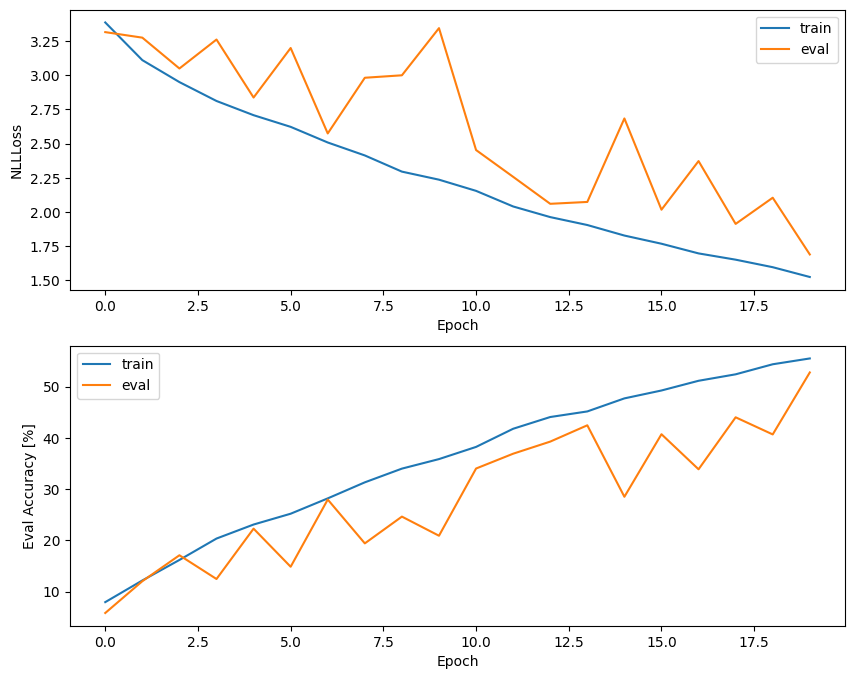

In [26]:
tracker = EmissionsTracker()
tracker.start()
model_log = train_net(model, train_loader, val_loader, optimizer, hparams["epochs"])

emissions: float = tracker.stop()
mlflow.log_metric("Carbon Emissions in kg", emissions)

print(f"Carbon Emissions: {emissions} kg")

In [27]:
model_log

{'tr_losses': [3.3862489770395685,
  3.1105459840914693,
  2.9499230224865314,
  2.811800227759364,
  2.707887126234012,
  2.6225302828767427,
  2.508179954827403,
  2.4134290370697413,
  2.295055204687027,
  2.2361414440142844,
  2.154297306895637,
  2.0402011936084152,
  1.962401126139461,
  1.9044781302491698,
  1.827426525731437,
  1.7676341979267498,
  1.696830686669761,
  1.6509935657818096,
  1.59593552446213,
  1.5242873628299458],
 'te_losses': [3.3154979526616963,
  3.275058538291105,
  3.0494781071972694,
  3.2612763711601307,
  2.8370844209270114,
  3.1992948283055784,
  2.5742848678758947,
  2.9816932253017545,
  2.999629515751152,
  3.3446412876153446,
  2.452920903066161,
  2.256981239956655,
  2.059630378036742,
  2.0732817505575287,
  2.6840007730350375,
  2.0165994007875967,
  2.372197132961006,
  1.9126235535190363,
  2.104113833919452,
  1.6891060126055577],
 'tr_accs': [7.95,
  12.175,
  16.175,
  20.35,
  23.085,
  25.195,
  28.185,
  31.315,
  33.99,
  35.85,
  3

In [28]:
mlflow.end_run()

## **Conclusions**

In this project, we have developed and deployed an automated food recognition tool using deep learning techniques. This tool allows users to upload food images and obtain information about the dishes, such as their names, origins, and nutritional content. Our goal was to create a highly accurate food classifier to provide users with authentic information.

The implications of this project are significant, as it can aid in dietary assessment and help people discover more about the food they consume. We look forward to integrating this technology into our daily lives to improve its quality.

Thank you for following along with our project!